In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


ROTATION = 30
GROUP_SECONDS = 5


def create_gruop_key(df, seconds, col_name="key"):
    key = df.iloc[0, :].time

    result = []
    
    for idx, row in df.iterrows():
        result.append(key)
        
        if (row.timestamp.second % seconds == 0):
            key = row.time
    
    df[col_name] = result


def mean_latency(ax, dfl):
    mean = np.mean(dfl.latency_ms)
    latency_mean = [mean]*len(dfl.index)
    
    pctl = np.percentile(dfl.latency_ms, 75)
    latency_pct = [pctl]*len(dfl.index)

    ax.grid(linestyle="--")
    ax.plot(dfl.index, dfl.latency_ms, linestyle='-', color="green", marker="o", label="Latência")

    ax.plot(dfl.index, latency_mean, label=f'Média ({int(mean)})', linestyle='--', color="tab:blue")
    ax.plot(dfl.index, latency_pct, label=f'75% ({int(pctl)})', linestyle='--', color="tab:orange")

    ax.set_title("Latência Média")
    ax.set_ylabel("Latência (ms)")
    ax.legend()

    for label in ax.get_xticklabels():
        label.set_rotation(ROTATION)

def req_per_second(ax, dfl):
    ax.set_title("Requisições Por Segundo")
    ax.plot(dfl.index, dfl.rate, linestyle='-', color="grey", marker="o")
    ax.grid(linestyle="--")
    ax.set_ylabel("Requisições (s)")

    for label in ax.get_xticklabels():
        label.set_rotation(ROTATION)

def errors_and_reqs(ax, df_err):
    ax.set_title("Erros (KOs) / Requisições Por Segundo") 
    ax.plot(df_err.index, df_err.rate, linestyle='-', color="grey")
    ax.plot(df_err.index, df_err.error_bool, linestyle='-', color="tab:red")
    ax.grid(linestyle="--")
    ax.set_ylabel("Requisições (s) / Errors")
    ax.set_xticks([])

    for label in ax.get_xticklabels():
        label.set_rotation(ROTATION)

def success_and_errors(ax, df):
    success = df.loc[df["error"] == ""].count().iloc[0]
    error = df.loc[df["error"] != ""].count().iloc[0]
    
    values = [success, error]

    tot = success.sum() + error.sum()
    
    ax.set_title("Sucesso x Erros") 
    bar1 = ax.bar(["success"], success, color=["tab:green"])
    bar2 = ax.bar(["error (KOs)"], error, color=["tab:red"])

    for rect in bar1 + bar2:
        height = rect.get_height()
        percent = int(height / tot * 100)
        ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height} ({percent}%)', ha='center', va='bottom')

def generate_report(fpath: str, request_id: str):
    df = pd.read_json(fpath)

    df["time"] = df.timestamp.apply(lambda x: x.strftime("%H:%M:%S"))
    df["error_bool"] = df.error.apply(lambda x: x != "")
    create_gruop_key(df, GROUP_SECONDS)
    create_gruop_key(df, 1, "key_one_sec")

    dfl = df[df["error"] == ""].groupby("key").agg({"latency_ms": "mean", "rate": "mean"})
    dfl["latency_ms"] = dfl.latency_ms.round(0)
    df_err = df.groupby("key_one_sec").agg({"rate": "mean", "error_bool": "sum"})

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    mean_latency(ax[0][0], dfl)

    req_per_second(ax[0][1], dfl)

    errors_and_reqs(ax[1][0], df_err)

    success_and_errors(ax[1][1], df)

    fig.tight_layout()

    fig.subplots_adjust(top=0.94)

    outfig = fpath.split(".")[0] + ".png"

    fig.suptitle(request_id, y=1, fontweight="bold")

    fig.savefig(outfig)


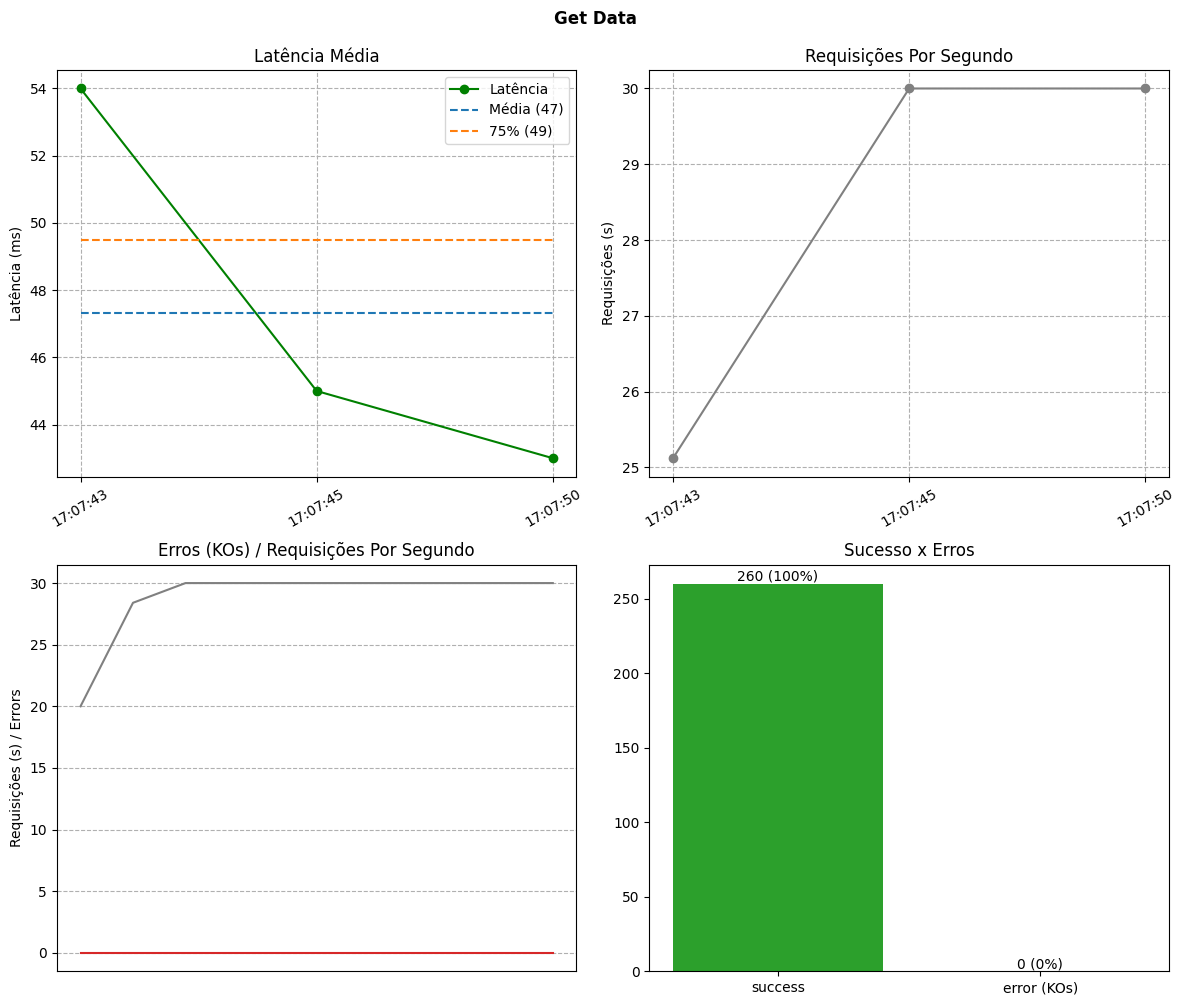

In [140]:
generate_report("results/result_get-data.json", "Get Data")